## Import data and set up parameters

In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from utils import *
import torch
from torch import nn
from torch.nn import functional as F

torch.use_deterministic_algorithms(True)
from easydict import EasyDict as ed
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from skopt.space import Real, Integer, Categorical
from captum.attr import FeaturePermutation

np.random.seed(0)
torch.manual_seed(0)
import random
random.seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

split_by = 'random' # 'random' or 'material'

validation = True
physics_informed = False
bayes_opt = False

data_path = '../data/SNL_MSU_DOE_fatigue.xlsx'
ckp_path = '../output/fatigue.pt'
skopt_path = '../output/skopt.pt'

if split_by == 'random':
    static_params = {'patience': 500, 'epoch': 2000}
    chosen_params = {'lr': 0.0034560325081541875, 'weight_decay': 0.0019904362054363267, 'batch_size': 1024} # for random split
    layers = [16, 64, 128, 128, 64, 16]
    n_calls = 200
    SPACE = [
        Real(1e-3, 0.05, 'log-uniform', name='lr'),
        Real(1e-5, 0.05, 'log-uniform', name='weight_decay'),
        Categorical([32, 64, 128, 256, 512, 1024, 2048, 4096], name='batch_size'),
    ]
elif split_by == 'material':
    static_params = {'patience': 200, 'epoch': 2000}
    # chosen_params = {'lr': 0.03858073169465622, 'weight_decay': 0.01979435727033024, 'batch_size': 128}
    chosen_params = {'lr': 0.03987750059057139, 'weight_decay': 0.007693132888108119, 'batch_size': 128}
    layers = [16, 64, 128, 128, 64, 16]
    n_calls = 400
    SPACE = [
        Real(1e-3, 0.1, 'log-uniform', name='lr'),
        Real(1e-3, 0.05, 'log-uniform', name='weight_decay'),
        Categorical([32, 64, 128, 256, 512, 1024, 2048, 4096], name='batch_size'),
    ]
else:
    raise Exception('Split not implemented.')

if physics_informed:
    loss_fn = PI_MSELoss()
else:
    loss_fn = nn.MSELoss()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cpu device


## Set datasets

In [13]:
data = pd.read_excel(data_path, engine='openpyxl')

feature_names = ['Percentage of Fibre in 0-deg Direction',
                 'Percentage of Fibre in 45-deg Direction',
                 'Percentage of Fibre in 90-deg Direction',
                 'Percentage of Fibre in Other Direction',
                 'Absolute Maximum Stress',
                 'Absolute Peak-to-peak Stress',
                 'Frequency',
                 'Fibre Volumn Fraction',
                 'Relative Maximum Stress',
                 'Relative Peak-to-peak Stress',
                 'Thickness',
                 'Static Maximum Tensile Stress',
                 'Static Maximum Tensile Strain',
                 'Static Elastic Modulus']

label_name = ['Cycles to Failure']

feature_data, label_data, X, y, train_dataset, val_dataset, test_dataset, scaler = split_dataset(data, feature_names, label_name, device, validation, split_by)

Dataset size: 2884 961 963


## Gaussian process-based Bayes hyperparameter optimization (Optional)

In [14]:
if bayes_opt:
    bar = tqdm(total=n_calls)

    @skopt.utils.use_named_args(SPACE)
    def objective(**params):
        res = model_train(train_dataset, test_dataset, val_dataset, layers, validation, loss_fn, ckp_path, device,
                          verbose=False, return_loss_list=False, **{**params, **static_params})

        return res

    postfix = {'Current loss': 1e8, 'Minimum': 1e8, 'Params': list(chosen_params.values()), 'Minimum at call': 0}

    def callback(result):
        postfix['Current loss'] = result.func_vals[-1]

        if result.fun < postfix['Minimum']:
            postfix['Minimum'] = result.fun
            postfix['Params'] = result.x
            postfix['Minimum at call'] = len(result.func_vals)
        skopt.dump(result, skopt_path)

        if len(result.func_vals) % 5 == 0:
            plt.figure()
            ax = plt.subplot(111)
            ax = plot_convergence(result, ax)
            plt.savefig('../output/skopt_convergence.svg')
            plt.close()

        bar.set_postfix(**postfix)
        bar.update(1)

    result = gp_minimize(objective, SPACE, n_calls=n_calls, random_state=0, x0=list(chosen_params.values()),
                         callback=callback)
    print(result.func_vals.min())

    params = {}
    for key,value in zip(chosen_params.keys(), result.x):
        params[key] = value

    print(params)

else:
    params = chosen_params

## Training

In [15]:
model = NN(len(feature_names),len(label_name), layers).to(device)

min_loss,train_ls,val_ls = model_train(train_dataset, test_dataset, val_dataset, layers, validation, loss_fn, ckp_path, device, model = model, verbose_per_epoch=100, **{**params, **static_params})

if validation:
    model.load_state_dict(torch.load(ckp_path))
else:
    torch.save(model.state_dict(), ckp_path)

print('Minimum loss:', min_loss)

Epoch: 1/2000, Train loss: 13.7008, Val loss: 5.9789
Epoch: 100/2000, Train loss: 0.2890, Val loss: 0.3539
Epoch: 200/2000, Train loss: 0.2263, Val loss: 0.4057
Epoch: 300/2000, Train loss: 0.2241, Val loss: 0.3596
Epoch: 400/2000, Train loss: 0.2017, Val loss: 0.3303
Epoch: 500/2000, Train loss: 0.2035, Val loss: 0.3060
Epoch: 600/2000, Train loss: 0.1841, Val loss: 0.3774
Epoch: 700/2000, Train loss: 0.1928, Val loss: 0.3075
Epoch: 800/2000, Train loss: 0.1669, Val loss: 0.3650
Epoch: 900/2000, Train loss: 0.1699, Val loss: 0.3194
Epoch: 1000/2000, Train loss: 0.1696, Val loss: 0.3133
Epoch: 1100/2000, Train loss: 0.1657, Val loss: 0.3247
Epoch: 1200/2000, Train loss: 0.1640, Val loss: 0.2992
Epoch: 1300/2000, Train loss: 0.1684, Val loss: 0.3208
Epoch: 1400/2000, Train loss: 0.1438, Val loss: 0.3096
Epoch: 1500/2000, Train loss: 0.1444, Val loss: 0.3213
Epoch: 1600/2000, Train loss: 0.1429, Val loss: 0.3497
Epoch: 1700/2000, Train loss: 0.1571, Val loss: 0.2863
Early stopping at epo

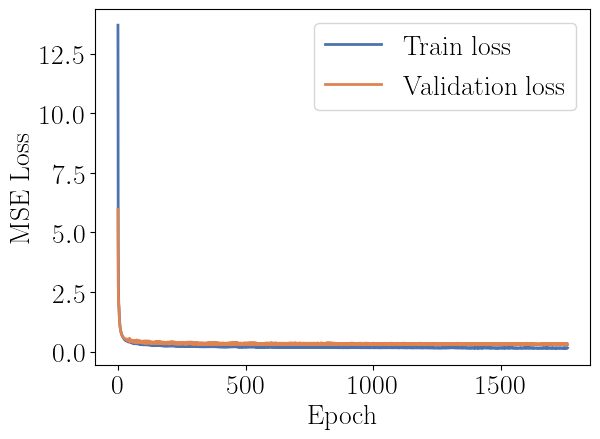

In [16]:
plt.figure()
plt.rcParams['font.size'] = 20
ax = plt.subplot(111)
plot_loss(train_ls, val_ls, ax)
plt.savefig('../output/loss_epoch.svg')
if is_notebook():
    plt.show()
plt.close()

## Plot results and compare NN with baseline models

Train MSE Loss: 0.1331, R2: 0.9223
Validation MSE Loss: 0.2809, R2: 0.8341
Test MSE Loss: 0.2918, R2: 0.8262


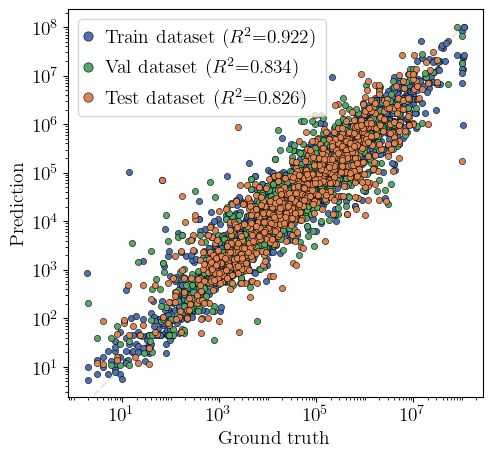

In [17]:
plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)
plot_truth_pred_NN(train_dataset, val_dataset, test_dataset, model, loss_fn, ax)
plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

Train MSE Loss: 0.0733, R2: 0.9572
Test MSE Loss: 0.3139, R2: 0.8130


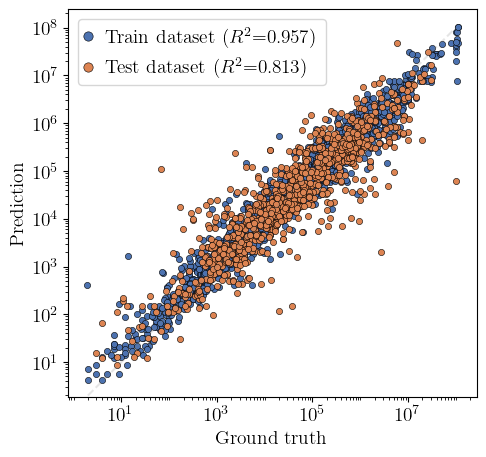

In [18]:
plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

if split_by == 'material':
    rf = RandomForestRegressor(n_jobs=-1, max_depth=6)
else:
    rf = RandomForestRegressor(n_jobs=-1, max_depth=15)

plot_truth_pred_sklearn(feature_data, label_data, train_dataset.indices, test_dataset.indices, ax, model = rf, split_by = split_by)
plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/rf_truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

Train MSE Loss: 0.9655, R2: 0.4359
Test MSE Loss: 0.9330, R2: 0.4442


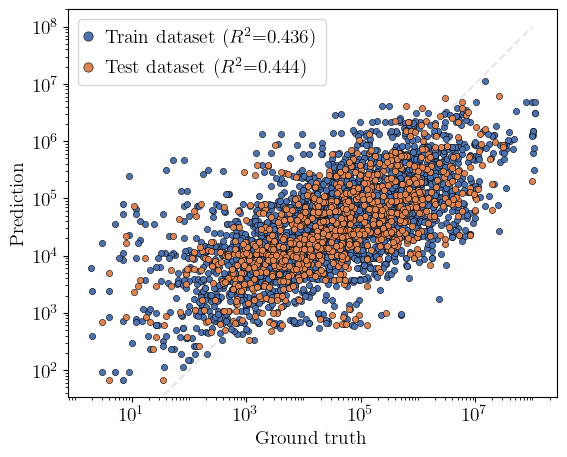

In [19]:
from sklearn import svm


plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

sv = svm.SVR()
plot_truth_pred_sklearn(feature_data, label_data, train_dataset.indices, test_dataset.indices, ax, model = sv, split_by = split_by)

plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/sv_truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

## Permutation feature importance

In [28]:
def forward_func(data):
    prediction, ground_truth, loss = test_tensor(data, y[test_dataset.indices,:], model, loss_fn)
    return loss

feature_perm = FeaturePermutation(forward_func)
attr = feature_perm.attribute(X[test_dataset.indices,:]).cpu().numpy()[0]

/home/xlluo/hdd/ML-fracture/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


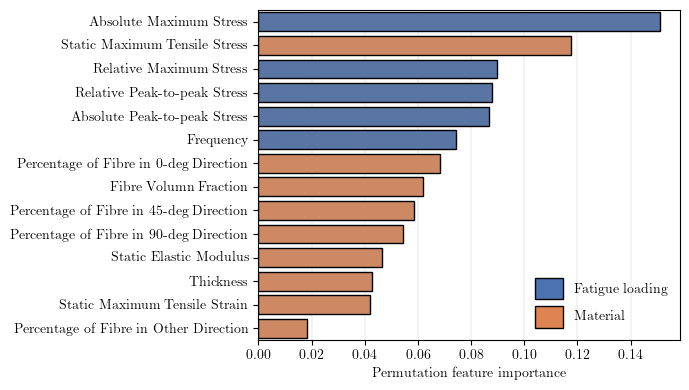

In [39]:
from utils import plot_importance
clr = sns.color_palette('deep')

load_features = [
    'Absolute Maximum Stress',
    'Absolute Peak-to-peak Stress',
    'Frequency',
    'Relative Maximum Stress',
    'Relative Peak-to-peak Stress',
]

material_features = [
    'Percentage of Fibre in 0-deg Direction',
    'Percentage of Fibre in 45-deg Direction',
    'Percentage of Fibre in 90-deg Direction',
    'Percentage of Fibre in Other Direction',
    'Fibre Volumn Fraction',
    'Thickness',
    'Static Maximum Tensile Stress',
    'Static Maximum Tensile Strain',
    'Static Elastic Modulus'
]

pal = [
    clr[0] if x in load_features else clr[1] for x in feature_names
]

plt.figure(figsize=(7,4))
ax = plt.subplot(111)
plot_importance(ax, feature_names, attr, pal = pal, clr_map = {'Fatigue loading': clr[0], 'Material': clr[1]}, linewidth=1, edgecolor='k')
plt.tight_layout()

plt.savefig('../output/feature_importance.png', dpi=600)
# plt.close()
if is_notebook():
    plt.show()
plt.close()

## Partial dependence

Calculate PDP:  Percentage of Fibre in 0-deg Direction
Calculate PDP:  Percentage of Fibre in 45-deg Direction
Calculate PDP:  Percentage of Fibre in 90-deg Direction
Calculate PDP:  Percentage of Fibre in Other Direction
Calculate PDP:  Absolute Maximum Stress
Calculate PDP:  Absolute Peak-to-peak Stress
Calculate PDP:  Frequency
Calculate PDP:  Fibre Volumn Fraction
Calculate PDP:  Relative Maximum Stress
Calculate PDP:  Relative Peak-to-peak Stress
Calculate PDP:  Thickness
Calculate PDP:  Static Maximum Tensile Stress
Calculate PDP:  Static Maximum Tensile Strain
Calculate PDP:  Static Elastic Modulus
(14, 12) 4 4


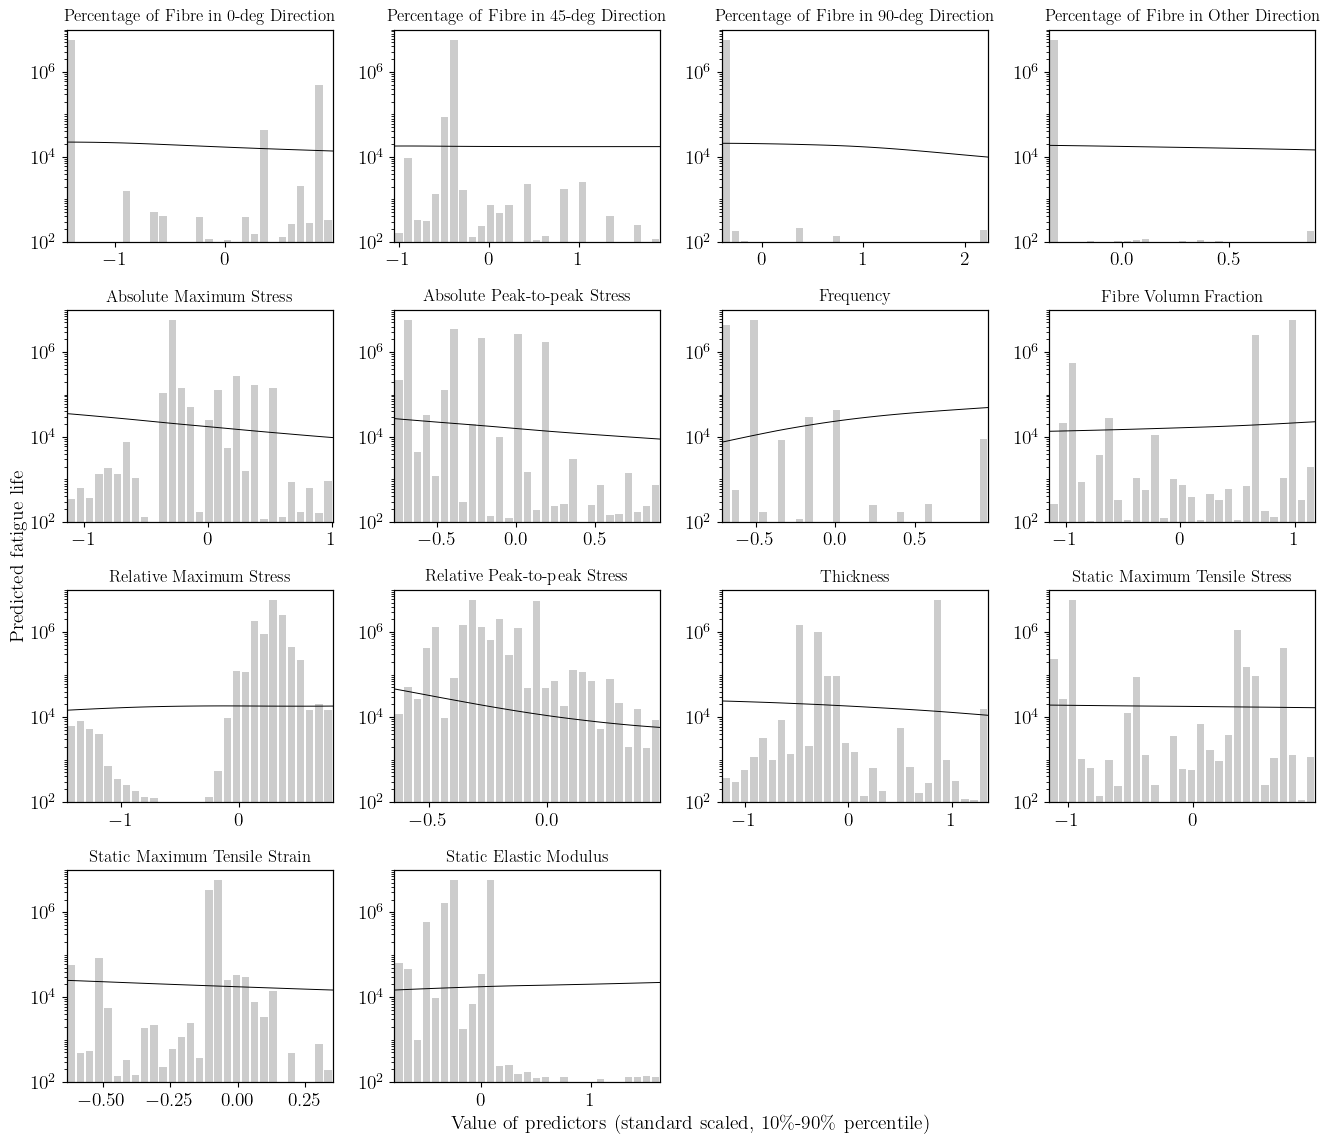

In [11]:

from utils import calculate_pdp
x_values_list = []
mean_pdp_list = []


for feature_idx in range(len(feature_names)):
    print('Calculate PDP: ',feature_names[feature_idx])
    
    pdp_list = []
    ci_left = []
    ci_right = []
    x_value, model_predictions = calculate_pdp(model,X[train_dataset.indices,:],feature_idx,grid_size=30)
    
    x_values_list.append(x_value)
    mean_pdp_list.append(model_predictions)

fig=plot_pdp(feature_names, x_values_list, mean_pdp_list, X, train_dataset.indices)

plt.savefig('../output/partial_dependence.svg')
if is_notebook():
    plt.show()
plt.close()